In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues
from bold_dementia.utils.iterables import unique

ATLAS = "gillig-regions"
SOFT = False
ALPHA = config["alpha"]

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [4]:
expname = f"atlas-{ATLAS}_default_ols-cenanom"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
print(f"Loading matrices from {matrices_path}")
#AD_matrices = joblib.load(matrices_path / "AD.joblib")
#control_matrices = joblib.load(matrices_path / "control.joblib")
fdrmat = joblib.load(matrices_path / "pmat.joblib")
tstats = joblib.load(matrices_path / "statmap.joblib")

#n_AD = AD_matrices.shape[0]
#n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-gillig-regions_default_ols-cenanom


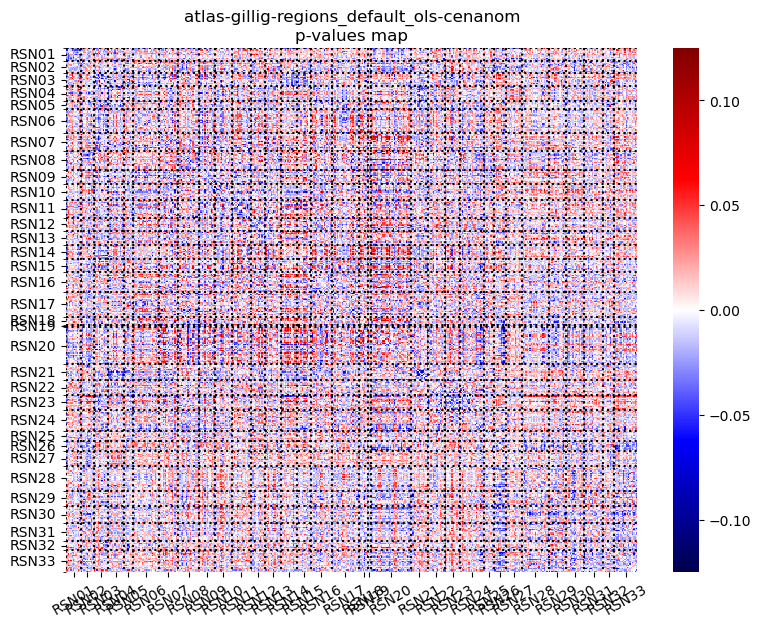

In [5]:
from bold_dementia.connectivity import plot_ordered_matrix

plot_matrix(tstats, atlas)
plt.title(f"{expname}\np-values map")
plt.show()

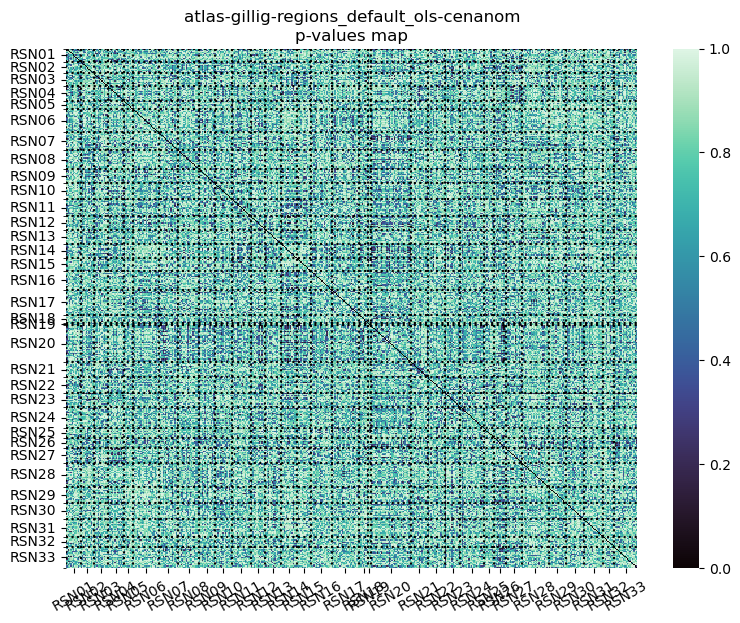

In [6]:
from bold_dementia.connectivity import plot_ordered_matrix

plot_matrix(fdrmat, atlas, bounds=(0, 1), cmap="mako")
plt.title(f"{expname}\np-values map")
plt.show()

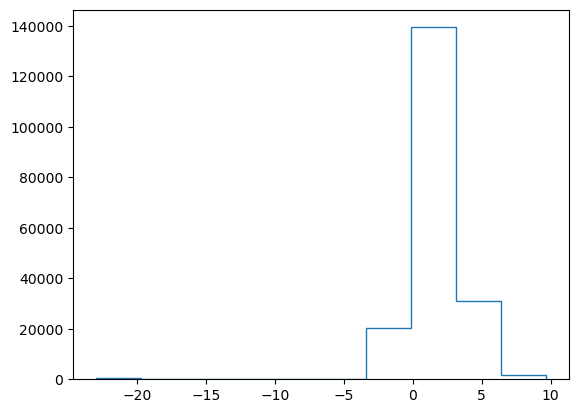

In [7]:
from scipy.special import logit
eps = 1e-10
plt.hist(logit(fdrmat.flatten() + eps), histtype="step")
plt.show()

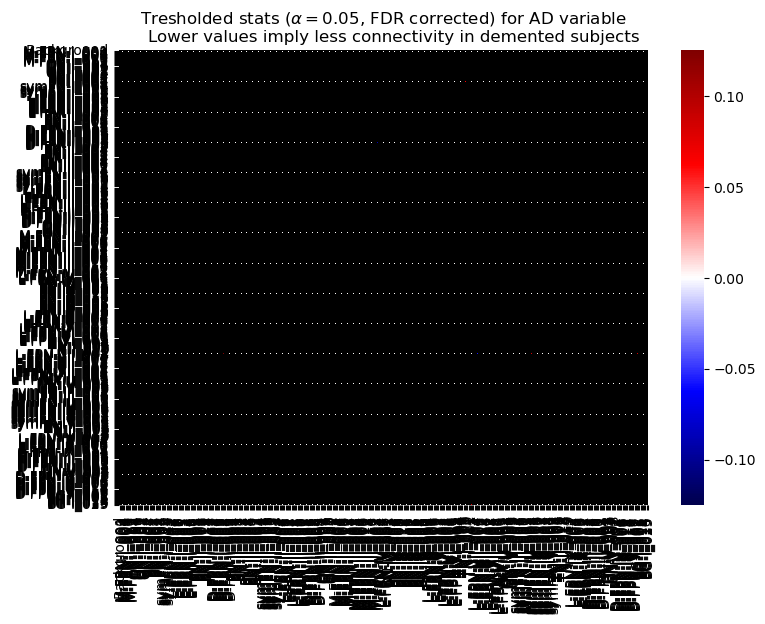

In [8]:

thresholded_t = tstats * np.where(fdrmat < 0.1, 1, 0)

plot_ordered_matrix(thresholded_t, atlas)

plt.title("Tresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

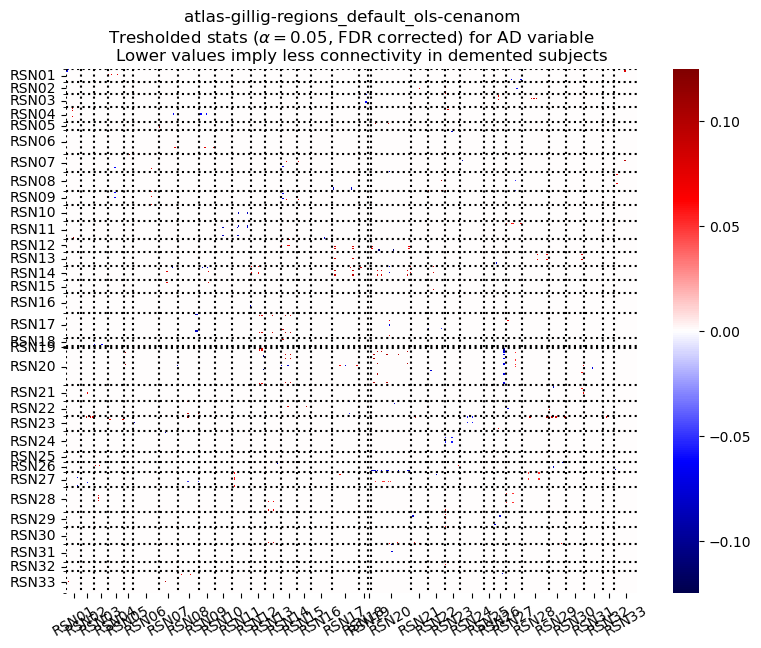

In [11]:
plot_matrix(thresholded_t, atlas)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

In [12]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]

In [27]:
labels = [label for label in atlas.labels if label != "Background"]
dict(zip(labels, atlas.macro_labels))

{'M-FPN-I_001': 'RSN01',
 'M-FPN-I_002': 'RSN01',
 'M-FPN-I_004': 'RSN01',
 'M-FPN-I_006': 'RSN01',
 'M-FPN-I_007': 'RSN01',
 'M-FPN-I_008': 'RSN01',
 'M-FPN-I_009': 'RSN01',
 'M-FPN-I_010': 'RSN01',
 'M-FPN-I_011': 'RSN01',
 'M-FPN-I_012': 'RSN01',
 'M-FPN-I_013': 'RSN01',
 'ON-I_002': 'RSN03',
 'ON-I_003': 'RSN03',
 'ON-I_004': 'RSN03',
 'ON-I_005': 'RSN03',
 'ON-I_006': 'RSN03',
 'ON-I_001': 'RSN03',
 'PN-I_001': 'RSN04',
 'PN-I_002': 'RSN04',
 'PN-I_004': 'RSN04',
 'PN-I_005': 'RSN04',
 'PN-I_003': 'RSN04',
 'symFN-I_003': 'RSN05',
 'symFN-I_004': 'RSN05',
 'symFN-I_006': 'RSN05',
 'symFN-I_012': 'RSN05',
 'symFN-I_013': 'RSN05',
 'symFN-I_014': 'RSN05',
 'symFN-I_015': 'RSN05',
 'L-FPN-I_001': 'RSN06',
 'L-FPN-I_002': 'RSN06',
 'L-FPN-I_003': 'RSN06',
 'L-FPN-I_004': 'RSN06',
 'L-FPN-I_005': 'RSN06',
 'L-FPN-I_007': 'RSN06',
 'L-FPN-I_008': 'RSN06',
 'L-FPN-I_009': 'RSN06',
 'L-FPN-I_010': 'RSN06',
 'L-FPN-I_011': 'RSN06',
 'L-FPN-I_006': 'RSN06',
 'PN-II_001': 'RSN09',
 'PN-II_00

In [28]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

RSN01       (0, 11)
RSN02      (11, 21)
RSN03      (21, 32)
RSN04      (32, 44)
RSN05      (44, 51)
RSN06      (51, 71)
RSN07      (71, 86)
RSN08     (86, 102)
RSN09    (102, 114)
RSN10    (114, 127)
RSN11    (127, 142)
RSN12    (142, 153)
RSN13    (153, 165)
RSN14    (165, 177)
RSN15    (177, 188)
RSN16    (188, 204)
RSN17    (204, 225)
RSN18    (225, 232)
RSN19    (232, 234)
RSN20    (234, 265)
RSN21    (265, 278)
RSN22    (278, 291)
RSN23    (291, 303)
RSN24    (303, 321)
RSN25    (321, 329)
RSN26    (329, 338)
RSN27    (338, 350)
RSN28    (350, 371)
RSN29    (371, 384)
RSN30    (384, 398)
RSN31    (398, 413)
RSN32    (413, 421)
RSN33    (421, 439)
dtype: object

In [15]:
from itertools import product
def block_block(matrix, network_to_idx):
    for network_a, network_b in product(network_to_idx.index, network_to_idx.index):
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            
            block_size = (loc_a[1] - loc_a[0]) * (loc_b[1] - loc_b[0])
            #block_activation = (n_negative_edges + n_negative_edges) / block_size
            block_activation = (n_negative_edges > 0) or (n_positive_edges > 0)

            yield network_a, network_b, n_positive_edges, n_negative_edges, block_activation
        

In [16]:
gen = block_block(block_mat, network_to_idx)
comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])

In [18]:
comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")

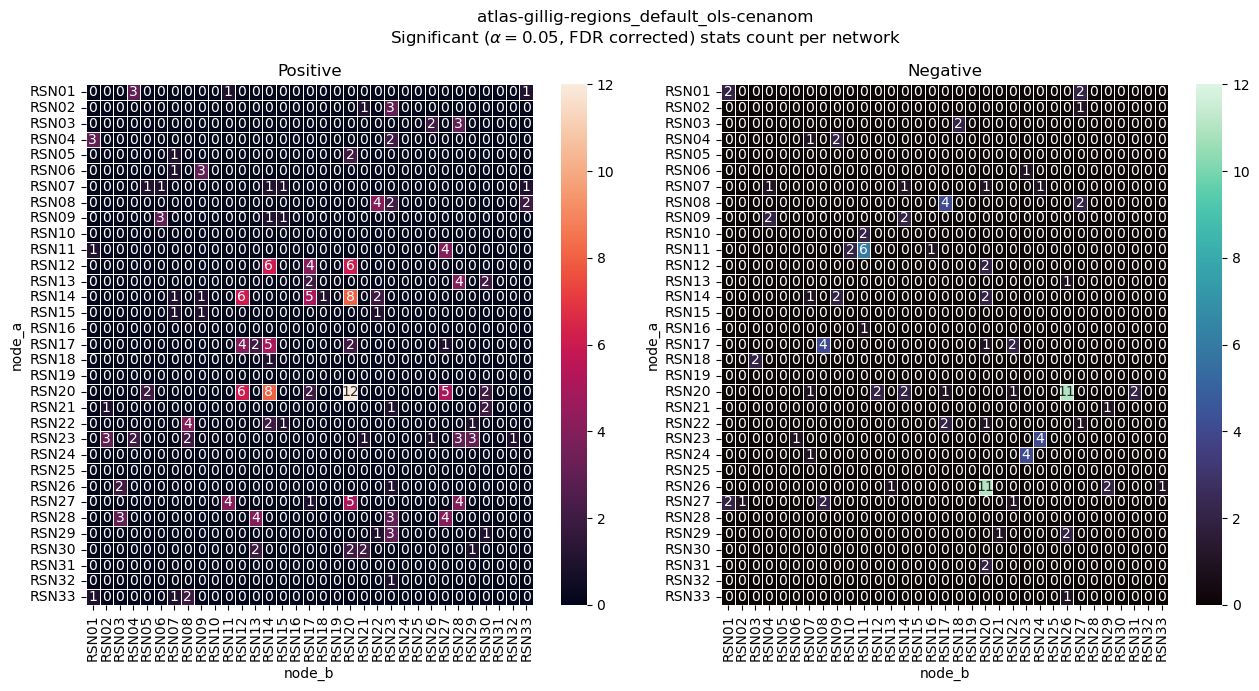

In [19]:
max_count = max(comparisons[["npos", "nneg"]].max())

heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(13, 7))
sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")

sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle(f"{expname}\nSignificant ($\\alpha = 0.05$, FDR corrected) stats count per network")
fig.tight_layout()
fig.show()

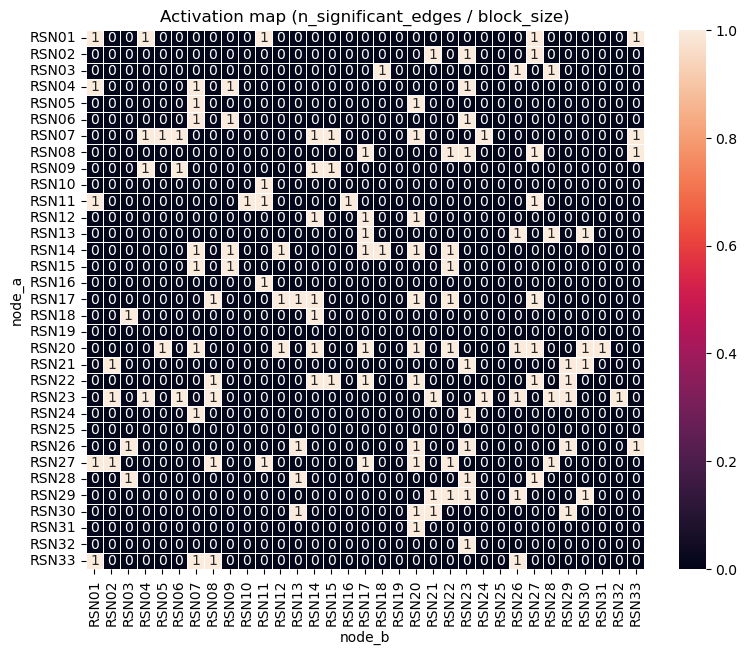

In [20]:
heat_k2 = heat_kwargs.copy()
heat_k2.pop("vmax")
plt.subplots(1, 1, figsize=(9, 7))
sns.heatmap(comparisons_pv.loc[:, "activation"], **heat_k2)
plt.title("Activation map (n_significant_edges / block_size)")
plt.show()

In [21]:
coords

array([[ 22.37623762, -36.07920792,   0.59405941],
       [-19.60344828, -37.43103448,   1.01724138],
       [  4.81481481, -42.        ,   9.11111111],
       ...,
       [-20.16666667, -72.22222222, -21.91666667],
       [ 20.4137931 , -72.55172414, -20.89655172],
       [ 22.94520548, -73.83561644, -49.08219178]])

In [22]:
atlas.labels

['Background',
 'M-FPN-I_001',
 'M-FPN-I_002',
 'M-FPN-I_004',
 'M-FPN-I_006',
 'M-FPN-I_007',
 'M-FPN-I_008',
 'M-FPN-I_009',
 'M-FPN-I_010',
 'M-FPN-I_011',
 'M-FPN-I_012',
 'M-FPN-I_013',
 'ON-I_002',
 'ON-I_003',
 'ON-I_004',
 'ON-I_005',
 'ON-I_006',
 'ON-I_001',
 'ON-I_002',
 'ON-I_001',
 'ON-I_002',
 'ON-I_003',
 'ON-I_004',
 'PN-I_001',
 'PN-I_002',
 'PN-I_004',
 'PN-I_005',
 'PN-I_001',
 'PN-I_002',
 'PN-I_003',
 'PN-I_004',
 'PN-I_001',
 'PN-I_002',
 'PN-I_003',
 'PN-I_004',
 'symFN-I_003',
 'symFN-I_004',
 'symFN-I_006',
 'symFN-I_012',
 'symFN-I_013',
 'symFN-I_014',
 'symFN-I_015',
 'L-FPN-I_001',
 'L-FPN-I_002',
 'L-FPN-I_003',
 'L-FPN-I_004',
 'L-FPN-I_005',
 'L-FPN-I_007',
 'L-FPN-I_008',
 'L-FPN-I_009',
 'L-FPN-I_010',
 'L-FPN-I_011',
 'L-FPN-I_001',
 'L-FPN-I_005',
 'L-FPN-I_001',
 'L-FPN-I_002',
 'L-FPN-I_003',
 'L-FPN-I_004',
 'L-FPN-I_005',
 'L-FPN-I_006',
 'L-FPN-I_007',
 'L-FPN-I_008',
 'PN-II_001',
 'PN-II_002',
 'PN-II_003',
 'PN-II_004',
 'PN-II_005',
 'PN-II_

In [23]:
view = plotting.view_connectome(tstats, coords, edge_threshold="90%")
view.open_in_browser()